In [14]:
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output
from google.colab.patches import cv2_imshow

from model import *
from utils import *
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [1]:
data_path = os.getcwd()
config_path=f'{data_path}/config/yolov3.cfg'
weights_path=f'{data_path}/config/yolov3.weights'
class_path=f'{data_path}/config/coco.names'
videopath = f'{data_path}/traffic.mp4'

In [38]:
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0

num_classes = 80
classes = load_classes(class_path)

model = Yolo(config_path)
model.load_weights(weights_path)
model.net_params["height"] = 416
inp_dim = int(model.net_params["height"])
model.to(device)
model.eval()
pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


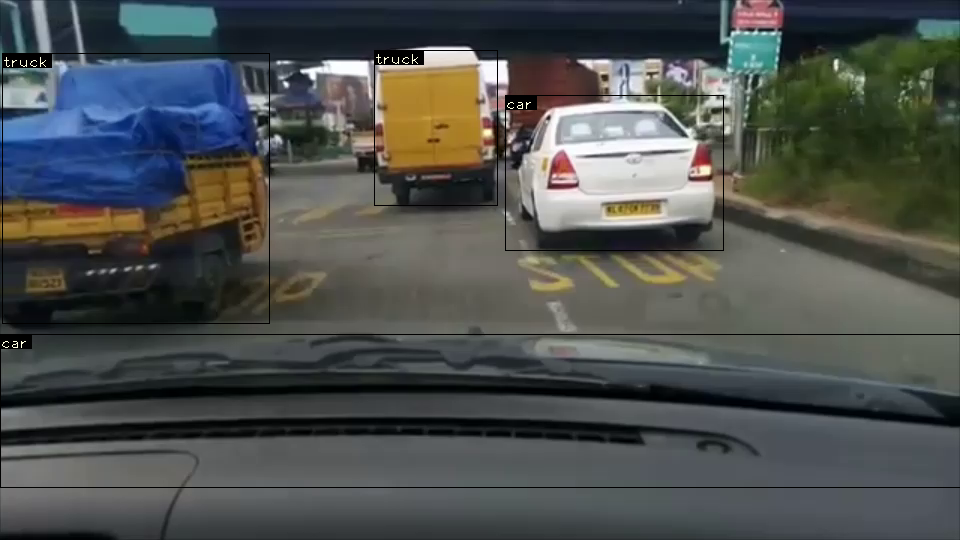

0.25345277786254883
FPS of the video is  3.94


In [78]:


vid = cv2.VideoCapture(videopath)  
frames = 0  
start = time.time()
temp = []
end = 0
while vid.isOpened():
    ret, frame = vid.read()
    
    if ret:   
        img = prep_image(frame, inp_dim)
        im_dim = frame.shape[1], frame.shape[0]
        im_dim = torch.FloatTensor(im_dim).repeat(1,2)   
                     
        
        im_dim = im_dim.to(device)
        img = img.to(device)
        
        with torch.no_grad():
            output = model(Variable(img, volatile = True), device)
        output = write_results(output, confidence, num_classes)


        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.4f}".format( frames / (time.time() - start)))
            cv2_imshow(frame)
            temp.append(frame)
            end += 1
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue
        
        
        

        im_dim = im_dim.repeat(output.size(0), 1)
        scaling_factor = torch.min(416/im_dim,1)[0].view(-1,1)
        
        output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
        output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2
        
        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])
    
        
        

        classes = load_classes(class_path)
        cmap = plt.get_cmap('tab20b')
        colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
        list(map(lambda x: write(x, frame), output))
        
        cv2_imshow(frame)
        temp.append(frame)

        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        frames += 1
        end += 1
        print(time.time() - start)
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
    
    # Delete loop below to get full output.
    if end > 1:
      break

    else:
        break     




In [67]:
import numpy as np
import skvideo.io

out_video =  np.empty([frames, temp[0].shape[0], temp[0].shape[1], temp[0].shape[2]], dtype = np.uint8)
out_video =  out_video.astype(np.uint8)

for i in range(len(temp)):
    img = temp[i]
    out_video[i] = img

skvideo.io.vwrite("traffic-yolo.mp4", out_video)